# IMDb with LSTMs
**7/17/2020**

Let's create a model that improves on the previous vanilla RNN. 

## Preprocessing Dataset

In [1]:
import torch
from torch import nn, optim
from torchtext import data, datasets
import spacy
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
import numpy as np
import random
import time
from livelossplot import PlotLosses
import warnings
warnings.filterwarnings('ignore')

We can import data and create a test/val/test split like in the last section. The concepts of building vocab and creating BucketIterators remain the same as before.

In [2]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LABEL = data.LabelField(dtype=torch.float)
TEXT = data.Field(include_lengths=True)
imdb = data.TabularDataset(path='imdb.json', format='JSON', fields=({'label': ('label',LABEL), 'text': ('text',TEXT)}))
train_set, temp = imdb.split(split_ratio=0.6, random_state=random.seed(0))
val_set, test_set = temp.split(split_ratio=0.5, random_state=random.seed(0))

print(f'Training set size:   {len(train_set)}')
print(f'Validation set size: {len(val_set)}')
print(f'Test set size:       {len(test_set)}')

Training set size:   30000
Validation set size: 10000
Test set size:       10000


In [6]:
TEXT.build_vocab(train_set, max_size = 25000, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_set)
print(TEXT.vocab.freqs.most_common(20))

[('the', 397969), ('.', 324479), (',', 324093), ('and', 192895), ('a', 191873), ('of', 172229), ('to', 160056), ('is', 128961), ('it', 113936), ('in', 111605), ('i', 104615), ('this', 89961), ('that', 86262), ('"', 77757), ("'s", 72818), ('-', 61786), ('was', 59883), ('as', 54536), ('movie', 52881), ('for', 52036)]


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_itr, val_itr, test_itr = data.BucketIterator.splits((train_set, val_set, test_set), batch_size = 64, sort_key = lambda x: len(x.text), sort_within_batch = True, device = device)

## Long Short-Term Memory
A LSTM is a RNN architecture that has a hidden state, similar to the previous vanilla RNN. However, a LSTM unit has a different structure composed of a cell, an input gate, an output gate and a forget gate. This structure allows the cell to learn and remember dependencies over longer periods than a vanilla RNN. The three gates also regulate the flow of information into and out of the cell to create a more complex memory system that creates both long and short term memory.

The model we use for reviews will remain the same as before, with an input, embedding, RNN, and fully connected linear output layer. The only difference is that the vanilla RNN layer is replaced with a LSTM layer. Using a LSTM alters the forward function slightly since there is now a cell along with the hidden state.

We can improve the LSTM by adding multiple layers. Tokens are fed into the bottom layer. The output is then sent to the cell in the layer above at the same time step. All layers still use the hidden state from the previous time step in the same layer.

We can also introduce bidirectionality, which allows one LSTM to process words forward (like how humans read) while another LSTM processes words backwards.

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional,
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        
        # pack
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # unpack
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden)

In [9]:
def accuracy(outputs, labels):
    rounded_outputs = torch.round(torch.sigmoid(outputs))
    correct = (rounded_outputs == labels).float()
    acc = correct.sum() / len(correct)
    return acc



def train(model, criterion, optimizer, iterator, device): 
    model.train()
    model = model.to(device)
    criterion = criterion.to(device)
    
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    for batch in train_itr:
        
        text, text_lengths = batch.text
        outputs = model(text, text_lengths).squeeze(1)
        loss = criterion(outputs, batch.label)
        acc = accuracy(outputs, batch.label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)



def evaluate(model, criterion, iterator, device):
    model.eval()
    model = model.to(device)
    criterion = criterion.to(device)
    
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    with torch.no_grad():
        for batch in iterator:
            
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = accuracy(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss/len(iterator), epoch_acc/len(iterator)



def train_val_model(model, criterion, optimizer, num_epochs, path):
    time_start = time.clock()
    best_val_loss = float('inf')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    liveloss = PlotLosses()
    
    for epoch in range(num_epochs):

        logs = {}
        train_loss, train_acc = train(model, criterion, optimizer, train_itr, device)
        val_loss, val_acc = evaluate(model, criterion, val_itr, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, path)

        logs['loss'] = train_loss
        logs['acc'] = train_acc
        logs['val_loss'] = val_loss
        logs['val_acc'] = val_acc
        
        liveloss.update(logs)
        liveloss.send()

    print('Training time: %.3fs' % round(time.clock()-time_start,3))

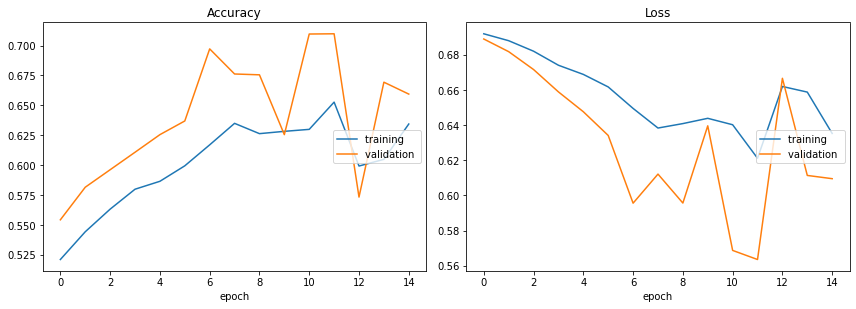

Accuracy
	training         	 (min:    0.521, max:    0.653, cur:    0.634)
	validation       	 (min:    0.554, max:    0.710, cur:    0.659)
Loss
	training         	 (min:    0.621, max:    0.692, cur:    0.635)
	validation       	 (min:    0.563, max:    0.689, cur:    0.609)
Training time: 1010.330s


In [10]:
model = LSTM(input_dim=len(TEXT.vocab), 
             embedding_dim=100,
             hidden_dim=256,
             output_dim=1,
             n_layers=2,
             bidirectional=True,
             dropout=0.5)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
num_epochs = 15
path = 'imdb_lstm.pt'

train_val_model(model, criterion, optimizer, num_epochs, path)

In [11]:
model = torch.load(path)
test_loss, test_acc = evaluate(model, criterion, test_itr, device)

print(f'Test loss: {test_loss:.3f}' )
print(f'Test accuracy: {(test_acc*100):.2f}%')

Test loss: 0.557
Test accuracy: 71.00%


71% accuracy is fairly good. We can still use pretrained word embeddings to further improve accuracy.

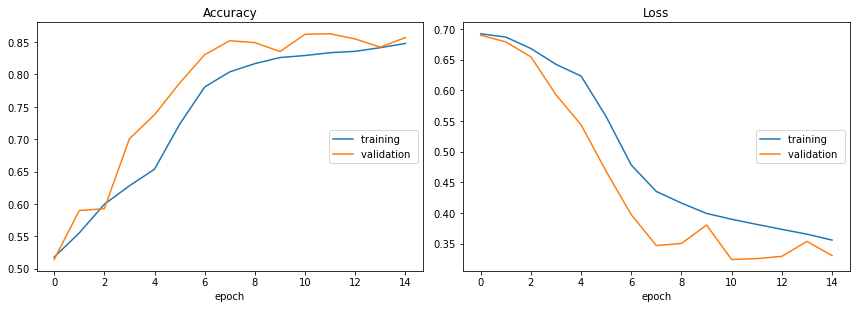

Accuracy
	training         	 (min:    0.518, max:    0.848, cur:    0.848)
	validation       	 (min:    0.514, max:    0.863, cur:    0.857)
Loss
	training         	 (min:    0.356, max:    0.692, cur:    0.356)
	validation       	 (min:    0.324, max:    0.690, cur:    0.330)
Training time: 1009.058s


In [19]:
model = LSTM(input_dim=len(TEXT.vocab), 
             embedding_dim=100,
             hidden_dim=256,
             output_dim=1,
             n_layers=2,
             bidirectional=True,
             dropout=0.5)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
num_epochs = 15
path = 'imdb_lstm.pt'

model.embedding.weight.data.copy_(TEXT.vocab.vectors)
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.unk_token]] = torch.zeros(model.embedding_dim)
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.pad_token]] = torch.zeros(model.embedding_dim)

train_val_model(model, criterion, optimizer, num_epochs, path)

In [20]:
model = torch.load(path)
test_loss, test_acc = evaluate(model, criterion, test_itr, device)

print(f'Test loss: {test_loss:.3f}' )
print(f'Test accuracy: {(test_acc*100):.2f}%')

Test loss: 0.337
Test accuracy: 85.48%


85% accuracy is impressive, but it can still be improved. Based on the accuracy and loss charts, more epochs would likely help. Increasing the number of LSTM layers and optimizing hyperparameters could possibly help as well.

The higher accuracy does come at the cost of longer computation time in comparison to the vanilla RNN. Nested cross validation would help get a better evaluation of the LSTM model, but that would likely take quite a long time. Nevertheless, we've shown that LSTMs perform fairly well with this dataset.